# Spotify Song Skipping Prediction Part II



## Dependencies

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Function for logging metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

def log_metrics(labels, preds, preds_proba, is_val=True):
    if is_val:
        pref = 'validation'
    else:
        pref = 'train'
    metrics = {}
    metrics[f"{pref}/accuracy_score"] = accuracy_score(labels, preds)
    metrics[f"{pref}/precision"] = precision_score(labels, preds, average="weighted")
    metrics[f"{pref}/recall"] = recall_score(labels, preds, average="weighted")
    metrics[f"{pref}/f1_score"] = f1_score(labels, preds, average="weighted")
    metrics[f"{pref}/roc_auc"] = roc_auc_score(labels, preds_proba)

    # Print metrics
    for k, v in metrics.items():
        print(f'{k} : {v}')

    # If ROC AUC is relevant, plot ROC curve
    fpr, tpr, thresholds = roc_curve(labels, preds_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % metrics[f"{pref}/roc_auc"])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

In [4]:
data = pd.read_csv('/content/drive/MyDrive/spotify_skip.csv')

In [5]:
print('Data size: {}\n'.format(len(data)))

Data size: 3106183



In [6]:
data.not_skipped.value_counts()

False    2022047
True     1084136
Name: not_skipped, dtype: int64

In [7]:
data.columns

Index(['session_id', 'session_position', 'session_length', 'track_id',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'duration', 'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
       'time_signature', 'valence', 'acoustic_vector_0', 'acoustic_vector_1',
       'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4',
       'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7', 'day',
       'month

In [8]:
data.head(3)

,session_id,session_position,session_length,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,day,month,year,years_since_release,since_session_start
0,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,1,20,t_86abc9b1-2a71-41d8-ab97-ac97ea20276a,True,True,True,False,0,0,...,-0.457729,0.161611,0.110725,-0.210354,0.290429,14,8,2018,12.0,200.546677
1,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,2,20,t_33a133e6-240c-467d-a5c5-a6729a545cc2,True,True,True,False,0,0,...,-0.650849,0.263819,0.192007,-0.208822,0.261239,14,8,2018,3.0,447.066406
2,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,3,20,t_cd87b117-d9d0-4562-b469-65ae0e88f8f5,True,True,True,False,0,1,...,-0.413609,-0.139509,0.159876,-0.349294,0.114625,14,8,2018,3.0,677.279739


In [9]:
# variables types

# categorical
cat_variable = ['mode', 'context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']

for c in cat_variable:
    data[c] = data[c].astype('category')

# boolean
bool_variable = ['context_switch', 'no_pause_before_play', 'short_pause_before_play', 'long_pause_before_play',
                'not_skipped', 'premium', 'hist_user_behavior_is_shuffle']

for b in bool_variable:
    data[b] = data[b].astype('bool')

In [10]:
data['prev_not_skipped'] = data.groupby(['session_id'])['not_skipped'].shift(1)
data['prev_not_skipped'] = data['prev_not_skipped'].astype('bool')

data['prev_duration'] = data.groupby(['session_id'])['duration'].shift(1)

In [11]:
data.dtypes

session_id                           object
session_position                      int64
session_length                        int64
track_id                             object
skip_1                                 bool
skip_2                                 bool
skip_3                                 bool
not_skipped                            bool
context_switch                         bool
no_pause_before_play                   bool
short_pause_before_play                bool
long_pause_before_play                 bool
hist_user_behavior_n_seekfwd          int64
hist_user_behavior_n_seekback         int64
hist_user_behavior_is_shuffle          bool
hour_of_day                           int64
date                                 object
premium                                bool
context_type                       category
hist_user_behavior_reason_start    category
hist_user_behavior_reason_end      category
duration                            float64
release_year                    


## Modeling

### I. Prediction based on Audio Features

Prediction of song skipping is based solely on the audio features of songs. The idea is to find if there's a consensus for song skipping across the population of music enthusiasts that is only dependent on the song itself.

In [12]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [13]:
# Ensure that the data is balanced
sub_data = data.groupby('not_skipped', group_keys=False).apply(lambda x: x.sample(1000000))

sub_data.not_skipped.value_counts()

False    1000000
True     1000000
Name: not_skipped, dtype: int64

In [14]:
song_features = ['duration', 'us_popularity_estimate', 'years_since_release',
                 'time_signature', 'key', 'mode']

audio_char = ['acousticness', 'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
              'energy', 'flatness', 'instrumentalness', 'liveness', 'loudness',
              'mechanism', 'organism', 'speechiness', 'tempo', 'valence',
              'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2',
              'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5',
              'acoustic_vector_6', 'acoustic_vector_7']

In [15]:
# One run to ensure that the model works
X_data = sub_data[song_features + audio_char]
Y_data = sub_data['not_skipped']

#### Trial Run

In [16]:
# Splitting the data between train, validation, and test

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

X_train.shape, X_val.shape, X_test.shape

((1440000, 29), (360000, 29), (200000, 29))

[LightGBM] [Info] Number of positive: 720201, number of negative: 719799
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.233180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6463
[LightGBM] [Info] Number of data points in the train set: 1440000, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500140 -> initscore=0.000558
[LightGBM] [Info] Start training from score 0.000558
Accuracy: 0.550
validation/accuracy_score : 0.5495305555555555
validation/precision : 0.5495700828375596
validation/recall : 0.5495305555555555
validation/f1_score : 0.5494584933399808
validation/roc_auc : 0.5712805794481778


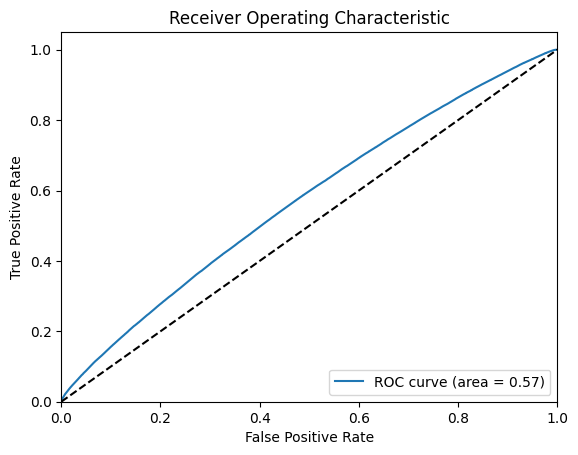

In [17]:
# LightGBM
model = lgbm.LGBMClassifier()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_val)[:, 1]  # Get probability of the positive class
y_pred = model.predict(X_val)
print('Accuracy: {:.3f}'.format(accuracy_score(y_val, y_pred)))

log_metrics(y_val, y_pred, y_pred_proba, is_val=True)


### II. Prediction based on Audio Features & User Behavior

In [18]:
user_behavior = ['context_switch', 'no_pause_before_play', 'short_pause_before_play',
                 'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
                 'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
                 'hour_of_day', 'premium', 'context_type', 'since_session_start']

In [19]:
# One run to ensure that the model works
X_data = sub_data[song_features + audio_char + user_behavior]
Y_data = sub_data['not_skipped']

#### Trial Run

In [20]:
# Splitting the data between train, validation, and test

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

X_train.shape, X_val.shape, X_test.shape

((1440000, 40), (360000, 40), (200000, 40))

[LightGBM] [Info] Number of positive: 720291, number of negative: 719709
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.182365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6800
[LightGBM] [Info] Number of data points in the train set: 1440000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500202 -> initscore=0.000808
[LightGBM] [Info] Start training from score 0.000808
Accuracy: 0.609
validation/accuracy_score : 0.6088805555555555
validation/precision : 0.611530861308072
validation/recall : 0.6088805555555555
validation/f1_score : 0.6065180051549862
validation/roc_auc : 0.6563796959260245


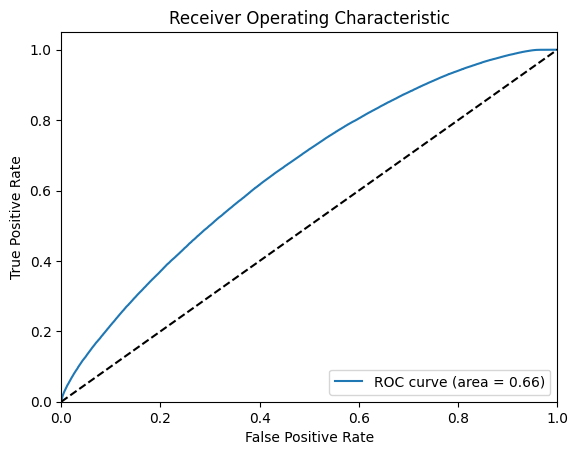

In [21]:
# LightGBM
model = lgbm.LGBMClassifier()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_val)[:, 1]  # Get probability of the positive class
y_pred = model.predict(X_val)
print('Accuracy: {:.3f}'.format(accuracy_score(y_val, y_pred)))

log_metrics(y_val, y_pred, y_pred_proba, is_val=True)


### III. Prediction based on Audio & User features + Feature Engineering

In [22]:
# One run to ensure that the model works
other_features = ['prev_not_skipped', 'prev_duration', 'session_position']

X_data = sub_data[song_features + audio_char + user_behavior + other_features]
Y_data = sub_data['not_skipped']

#### Trial Run

In [23]:
# Splitting the data between train, validation, and test

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

X_train.shape, X_val.shape, X_test.shape

((1440000, 43), (360000, 43), (200000, 43))

[LightGBM] [Info] Number of positive: 719702, number of negative: 720298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.319822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7074
[LightGBM] [Info] Number of data points in the train set: 1440000, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499793 -> initscore=-0.000828
[LightGBM] [Info] Start training from score -0.000828
Accuracy: 0.759
validation/accuracy_score : 0.7592083333333334
validation/precision : 0.7738742699354273
validation/recall : 0.7592083333333334
validation/f1_score : 0.7559516759471725
validation/roc_auc : 0.8246744650632707


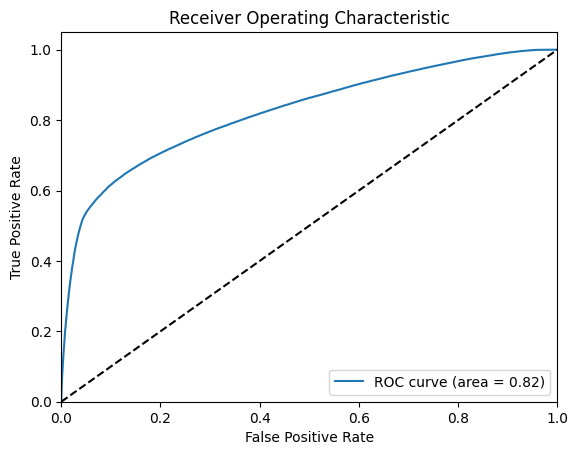

In [24]:
# LightGBM
model = lgbm.LGBMClassifier()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_val)[:, 1]  # Get probability of the positive class
y_pred = model.predict(X_val)
print('Accuracy: {:.3f}'.format(accuracy_score(y_val, y_pred)))

log_metrics(y_val, y_pred, y_pred_proba, is_val=True)
